### Logistic Regression with Oversampling using SMOTE

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import pandas as pd

# Load dataset with index and date parsing
lagged_1h_df = pd.read_csv("../data/athens_weather_df_2019_2023.csv", parse_dates=["date"])

In [3]:
import pickle

# Load the list of variables to transform
variables_to_transform_path = "../data/variables_to_transform.pkl"

with open(variables_to_transform_path, "rb") as f:
    variables_to_transform = pickle.load(f)

print(variables_to_transform)

['direct_radiation_lag_1h', 'cloud_cover_mid_lag_1h', 'cloud_cover_low_lag_1h', 'vapour_pressure_deficit_lag_1h', 'evapotranspiration_lag_1h']


Moving one step further we will try to address the challenges posed by the heavily imbalanced dataset, this time by employing an oversampling technique to balance the classes in the training data.   

In this iteration, we will use `SMOTE` (Synthetic Minority Over-sampling Technique) to generate artificial samples for the minority classes. Oversampling the minority classes helps to improve the model’s ability to make predictions, since by training the model on a balanced dataset, we aim to improve the recall for minority classes while maintaining the overall model accuracy.

SMOTE creates synthetic records by interpolating between existing samples of the minority class and their nearest neighbors. This approach increases the representation of minority classes in the training set, ensuring that each class is equally represented.   
The original test set is left untouched and retains its class imbalance so as to ensure an unbiased evaluation of the model’s performance on *real-life* terms.   

Further details on SMOTE can be found in the **[official documentation](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html)**.

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer, RobustScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
import time

# Define features (X) and target (y)
X = lagged_1h_df.drop(columns=['date', 'weather_event'])
y = lagged_1h_df['weather_event']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Define the preprocessing step for Yeo-Johnson transformation
preprocessor = ColumnTransformer([
    ('yeo_johnson', PowerTransformer(method='yeo-johnson'), variables_to_transform),
], remainder='passthrough', force_int_remainder_cols=False)  # Leave other features untouched

# Define the pipeline with SMOTE
oversampling_pipeline = Pipeline([
    ('preprocessing', preprocessor),   # Step 1: Yeo-Johnson transformation for specific variables
    ('scaling', RobustScaler()),       # Step 2: Scale all features
    ('smote', SMOTE(random_state=42)), # Step 3: Oversample the minority classes
    ('oversampling_model', LogisticRegression(
        max_iter=1500,
        random_state=42,
        solver='lbfgs',
        n_jobs=-1
    ))
])

# Fit the pipeline to the training data
start = time.time()
oversampling_pipeline.fit(X_train, y_train)
execution_time = time.time() - start

# Access fitted model and print details
oversampled_model_fitted = oversampling_pipeline['oversampling_model']
print(f"Execution time: {execution_time:.2f} seconds")
print(f"Number of iterations for convergence: {oversampled_model_fitted.n_iter_}")

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('yeo_johnson',
                                                  PowerTransformer(),
                                                  ['direct_radiation_lag_1h',
                                                   'cloud_cover_mid_lag_1h',
                                                   'cloud_cover_low_lag_1h',
                                                   'vapour_pressure_deficit_lag_1h',
                                                   'evapotranspiration_lag_1h'])])),
                ('scaling', RobustScaler()), ('smote', SMOTE(random_state=42)),
                ('oversampling_model',
                 LogisticRegression(max_iter=1500, n_jobs=-1,
                                    random_state=42))])

Execution time: 6.67 seconds
Number of iterations for convergence: [163]


#### **Model Evaluation**

##### **CV evaluation**

In [5]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
# Evaluate the model using cross-validation on the full data set
stkf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
smote_cv = cross_val_score(oversampling_pipeline, X_train, y_train, cv=stkf, scoring="balanced_accuracy", n_jobs=-1)

print(smote_cv)
print(f'\nThe mean value of balanced_accuracy on the cv evaluation is {smote_cv.mean().round(3)}')
print(f'\nThe standard deviation of balanced_accuracy on the cv evaluation is {smote_cv.std().round(3)}')
print('\n')

[0.83352349 0.91606948 0.85643077 0.92251318 0.92054223 0.85138091
 0.9157808  0.91970097 0.91506804 0.82504042]

The mean value of balanced_accuracy on the cv evaluation is 0.888

The standard deviation of balanced_accuracy on the cv evaluation is 0.038




##### **The Confusion Matrix**

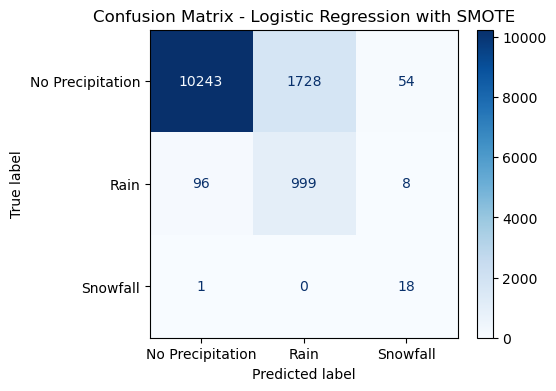

In [6]:
y_pred_smote = oversampling_pipeline.predict(X_test)
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
# Confusion Matrix
conf_matrix_smote = confusion_matrix(y_test, y_pred_smote)
fig, ax = plt.subplots(figsize=(5, 4))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_smote, display_labels=['No Precipitation', 'Rain', 'Snowfall'])
plot = disp.plot(ax=ax, cmap=plt.cm.Blues, values_format='d')
title = plt.title('Confusion Matrix - Logistic Regression with SMOTE')
plt.show()

- save the confusion matrix

In [7]:
from joblib import dump

# Define the file path
conf_matrix_path = "../reports/05_smote_logistic_regression_confusion_matrix.joblib"

# Save the confusion matrix
dump(conf_matrix_smote, conf_matrix_path)

print(f"SMOTE Logistic Regression confusion matrix saved at: {conf_matrix_path}")

['../reports/05_smote_logistic_regression_confusion_matrix.joblib']

SMOTE Logistic Regression confusion matrix saved at: ../reports/05_smote_logistic_regression_confusion_matrix.joblib


##### **The Precision-Recall Curve**

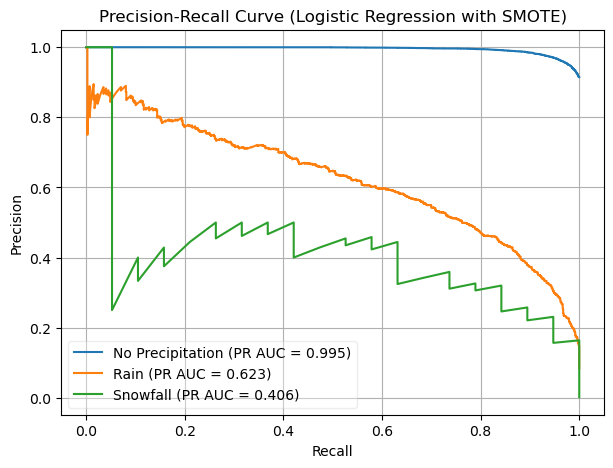

In [8]:
from sklearn.metrics import precision_recall_curve, auc
# Define the class labels
class_labels = ['No Precipitation', 'Rain', 'Snowfall']

# Producing the probabilities of each class for every data record in the test set
y_pred_probs_smote = oversampling_pipeline.predict_proba(X_test)

# Plot Precision-Recall curves
figure = plt.figure(figsize=(7, 5))  
for i, label in enumerate(class_labels):  
    precision, recall, _ = precision_recall_curve(y_test == i, y_pred_probs_smote[:, i])
    pr_auc = auc(recall, precision)
    
    # Plot the precision-recall curve
    plot = plt.plot(recall, precision, label=f'{label} (PR AUC = {pr_auc:.3f})')

xlabel = plt.xlabel('Recall')
ylabel = plt.ylabel('Precision')
title = plt.title('Precision-Recall Curve (Logistic Regression with SMOTE)')
legend = plt.legend(loc='lower left', framealpha=0.35)
grid = plt.grid(True)
plt.show()

##### **The Classification Report**

In [9]:
from sklearn.metrics import (
    classification_report, balanced_accuracy_score, f1_score, 
    average_precision_score, precision_recall_curve, auc
)
# Classification report
report_dict_smote = classification_report(y_test, y_pred_smote, digits=3, output_dict=True)

# Calculate PR AUC for each class
precision_0, recall_0, _ = precision_recall_curve(y_test == 0, y_pred_probs_smote[:, 0])
pr_auc_0 = auc(recall_0, precision_0)

precision_rain, recall_rain, _ = precision_recall_curve(y_test == 1, y_pred_probs_smote[:, 1])
pr_auc_rain = auc(recall_rain, precision_rain)

precision_snow, recall_snow, _ = precision_recall_curve(y_test == 2, y_pred_probs_smote[:, 2])
pr_auc_snow = auc(recall_snow, precision_snow)

# Create a single row dataframe with the required metrics
report_df_smote = pd.DataFrame({
    'precision_0': [report_dict_smote['0']['precision']],
    'recall_0': [report_dict_smote['0']['recall']],
    'f1_0': [report_dict_smote['0']['f1-score']],
    'pr_auc_0': [pr_auc_0],
    
    'precision_rain': [report_dict_smote['1']['precision']],
    'recall_rain': [report_dict_smote['1']['recall']],
    'f1_rain': [report_dict_smote['1']['f1-score']],
    'pr_auc_rain': [pr_auc_rain],
    
    'precision_snow': [report_dict_smote['2']['precision']],
    'recall_snow': [report_dict_smote['2']['recall']],
    'f1_snow': [report_dict_smote['2']['f1-score']],
    'pr_auc_snow': [pr_auc_snow],
    'balanced_accuracy': [balanced_accuracy_score(y_test, y_pred_smote)],
    'f1_macro': [f1_score(y_test, y_pred_smote, average='macro')],
    'pr_auc_macro': [average_precision_score(y_test, y_pred_probs_smote, average='macro')]

})

# Display the DataFrame
print('Logistic Regression with SMOTE')
report_df_smote = report_df_smote.round(4)
report_df_smote = report_df_smote.round(4)
report_df_smote

Logistic Regression with SMOTE


,precision_0,recall_0,f1_0,pr_auc_0,precision_rain,recall_rain,f1_rain,pr_auc_rain,precision_snow,recall_snow,f1_snow,pr_auc_snow,balanced_accuracy,f1_macro,pr_auc_macro
0,0.9906,0.8518,0.916,0.9948,0.3663,0.9057,0.5217,0.623,0.225,0.9474,0.3636,0.4062,0.9016,0.6004,0.6808


- save the metrics report

In [10]:
# Define the file path
report_path = "../reports/05_smote_logistic_regression_report.joblib"

# Save the report DataFrame
dump(report_df_smote, report_path)

print(f"SMOTE Logistic Regression report saved at: {report_path}")

['../reports/05_smote_logistic_regression_report.joblib']

SMOTE Logistic Regression report saved at: ../reports/05_smote_logistic_regression_report.joblib


##### **The learning curve**

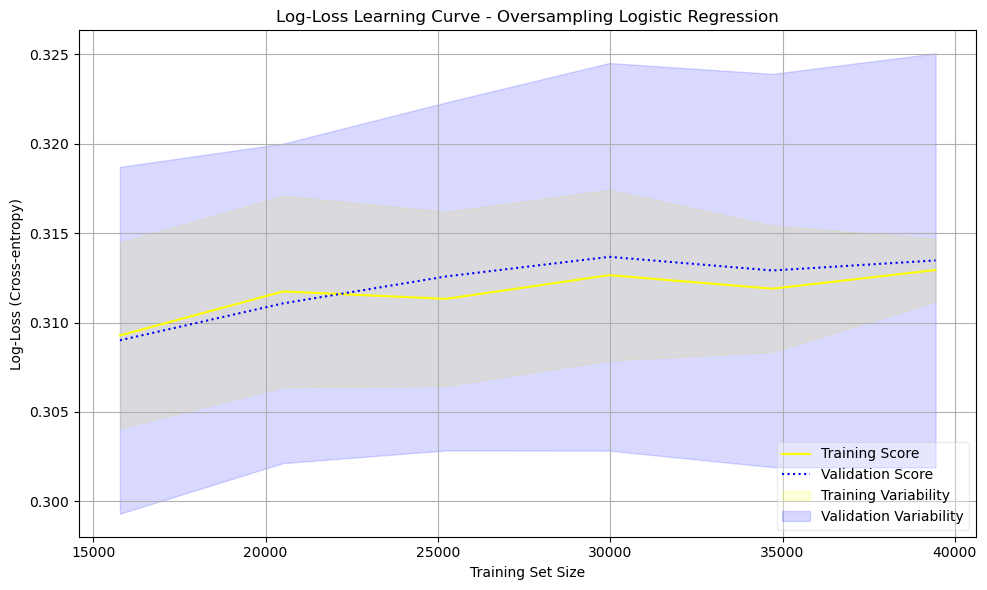

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, learning_curve
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

stkf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

train_sizes, train_scores, test_scores = learning_curve(
    oversampling_pipeline, X, y, cv=stkf, scoring='neg_log_loss', n_jobs=-1,
    train_sizes=np.linspace(0.4, 1.0, 6), shuffle=True, random_state=42
)

train_mean = -np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = -np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

figure = plt.figure(figsize=(10, 6))
plot1 = plt.plot(train_sizes, train_mean, label='Training Score', color='yellow')
plot2 = plt.plot(train_sizes, test_mean, label='Validation Score', color='blue', linestyle=':')
ce1_fill = plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='yellow', 
                            alpha=0.15, label='Training Variability')
ce2_fill = plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='blue', 
                            alpha=0.15, label='Validation Variability')

xlabel = plt.xlabel('Training Set Size')
ylabel = plt.ylabel('Log-Loss (Cross-entropy)')
title = plt.title('Log-Loss Learning Curve - Oversampling Logistic Regression')
legend = plt.legend(loc='lower right', framealpha=0.35)
grid = plt.grid(True)
plt.tight_layout()
plt.show()

The log-loss learning curve for the oversampled logistic regression model (SMOTE) was constructed for dataset sizes above 40% of the full dataset, as errors occurred in cross-validation when training sizes were too small to contain enough class 2 ('snowfall') instances.

The learning curves show that training and validation log-loss closely align, converging at approximately 0.314 when all data points are used, indicating no signs of overfitting or underfitting. This also represents an improvement compared to the weighted logistic regression model (~0.328 log-loss).

However, the validation variance is significantly higher, suggesting that predictions remain inconsistent across CV folds. This instability is likely due to the synthetic samples introduced by SMOTE, which may not accurately represent true minority class distributions.

**Save the Trained Model**

In [12]:
# Define the file path
model_path = "../models/smote_logistic_regression.joblib"

# Save the entire pipeline
dump(oversampling_pipeline, model_path)

print(f"SMOTE Logistic Regression model saved at: {model_path}")

['../models/smote_logistic_regression.joblib']

SMOTE Logistic Regression model saved at: ../models/smote_logistic_regression.joblib
